# Maggy Ablation: Feature and Model Ablation for the Titanic Dataset

*Last Updated: 2019/10/14*

In this notebook, we demonstrate Maggy's Ablation API, while using a TensorFlow Keras Sequential model trained on the [Titanic Dataset](https://www.kaggle.com/c/titanic/data). To be able to follow along, make sure you have the Titanic training dataset registered on your Project's Feature Store, as explained [in this example notebook](https://github.com/logicalclocks/hops-examples/blob/master/notebooks/featurestore/datasets/TitanicTrainingDatasetPython.ipynb).

## Wait ... What is an *Ablation Study*?

An Ablation Study, in medical and psychological research, is a research method in which the roles and functions of an organ, tissue, or any part of a living organism, is examined through its surgical removal and observing the behaviour of the organism in its absence. This method, also known as experimental ablation, was pioneered by the French physiologist [Marie Jean Pierre Flourens](https://en.wikipedia.org/wiki/Jean_Pierre_Flourens) in the early nineteenth century. Flourens would perform ablative brain surgeries on animals, removing different parts of their nervous systems and observing the effects on their behaviour. This method has since been used in a variety of disciplines, but most prominently in medical and psychological research and neuroscience.

## What Does it Have to Do with Machine Learning?

In the context of machine learning, we can define ablation study as *“a scientific examination of a machine learning system by removing its building blocks in order to gain insight on their effects on its overall performance”*. Dataset features and model components are notable examples of these building blocks (hence we use their corresponding terms of **feature ablation** and **model ablation**), but any design choice or module of the system may be included in an ablation study.

## Experiments and Trials

We can think that an ablation study is an *experiment* that consists of several *trials*. For example, each model ablation trial involves training a model with one or more of its components (e.g. a layer) removed. Similarly, a feature ablation trial involves training a model using a different set of dataset features, and observing the outcomes.

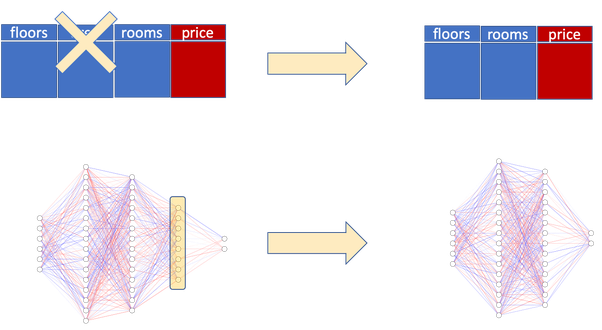

The image above shows a sample feature ablation trial (up) and a sample layer ablation trial (down). For example, in the sample layer ablation trial, we remove the last hidden layer from the base model, train the resulting model, and observe its accuracy.

## Ablation Studies with Maggy

With Maggy, performing ablation studies of your machine learning or deep learning systems is a fairly simple task that consists of the following steps:

1. Creating an `AblationStudy` instance,
2. Specifying the components that you want to ablate by *including* them in your `AblationStudy` instance,
3. Defining a *base model generator function* and/or a *dataset generator function*,
4. Wrapping your TensorFlow/Keras code in a Python function (let's call it **training function**) that receives two arguments (`model_function` and `dataset_function`), and
5. Launching your experiment with Maggy while specifying an *ablation policy*.

It's as simple as that.

## What Changes Should I Make in my TensorFlow/Keras Code?

Not so much. You'll see an example shortly, but the most important thing is:

- For **model ablation**, you need to define a function that returns a TF/Keras `model`, and use that in your code instead of defining the model in your training function. If you want to perform **layer ablation**, then you should provide a `name` argument while adding layers to your `tf.keras.Sequential` model, and include those names in your `AblationStudy` instance as well.

- For **feature ablation**:
    - if you have your training dataset in the [**Feature Store**](https://www.logicalclocks.com/featurestorepage) (congratulations! :D) in form of `tfrecord`, you can directly include the features you want to ablate using their names and calling a *dataset generator function* in your training function. The dataset generator functions will be created under the hood by maggy for each feature ablation trial.
    - alternatively, you can define your own *dataset generator function* and include it in your `AblationStudy` instance. A separate example notebook will be created to show you how you can do this.
    
Now let's see how this actually works.
Get your `SparkSession` by executing the following cell:

In [ ]:
import tensorflow as tf
from hops import hdfs
from hops import featurestore
import maggy

The next step is to create an `AblationStudy` instance. Here, the required arguments are 1) the name of your training dataset *as it is in your project's feature store*, and 2) * the name of the *label* column.

You can also provide the version of your training dataset in the feature store, but the default version is `1`.

In [ ]:
# create an AblationStudy instance.

from maggy.ablation import AblationStudy

ablation_study = AblationStudy('titanic_train_dataset', training_dataset_version=1,
                              label_name='survived')

## Feature Ablation

We perform feature ablation by **including** features in our `AblationStudy` instance. Including a feature means that there will be a trial where the model will be trained *without* that feature. In other words, you include features in the ablation study so that they will be excluded from the training dataset.

We have the following features in our training dataset:

`['age', 'fare', 'parch', 'pclass', 'sex', 'sibsp', 'survived']`

You can include features using `features.include()` method of your `AblationStudy` instance, by passing the names of the features, either separately or as a list of strings:

In [ ]:
#include features one by one

ablation_study.features.include('pclass')

# include a list of features

list_of_features = ['fare', 'sibsp']
ablation_study.features.include(list_of_features)

Let's see what features we have in our ablation study, using `features.list_all()`:

In [ ]:
ablation_study.features.list_all()

So, we have the above features *included* in our ablation study. Based on the configuration we have so far, once we launch the ablation study experiment we will have 4 trials:
- a trial with all the features, except for `fare`,
- another trial with all the features except `sibsp`,
- another one again with all the features, except for `pclass`,
- and of course, the **base trial** that has all the features of the training dataset.


Now let's see how we can perform model ablation with Maggy.

## Model Ablation

By *model ablation* we mean removing the *components* of the model and observing the resulting performance. Depending on which component of the model you want to ablate, we could have different types of model ablation, but one thing they all share in common is that we should have one *base model* in order to compare the other models with it. So we should define a *base model generator function* that returns a `tf.keras.Model`.

Maybe the simplest type of model ablation that can be performed on a sequential deep learning model is to remove some of its layers, so let's just do that. We call this *layer ablation*. In Keras, when you are adding layers to your `Sequential` model, you can provide a `name` argument with a custom name. The Maggy *ablator* then uses these `name`s to identify and remove the layers. Then, for each trial, the ablator returns a corresponding *model generator function* that differs from the base model generator in terms of its layers.

By the way, if you do not provide a `name` argument while adding a layer, that layer's name will be prefixed by its layer class name, followed by an incremental number, e.g., `dense_1`.

In the following cell, we define a base model generator function that once executed will return a `Sequential` model:

In [ ]:
# define the base model generator function

def base_model_generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(64, name='my_dense_two', activation='relu'))
    model.add(tf.keras.layers.Dense(32, name='my_dense_three', activation='relu'))
    model.add(tf.keras.layers.Dense(32, name='my_dense_four', activation='relu'))
    model.add(tf.keras.layers.Dense(2, name='my_dense_sigmoid', activation='sigmoid'))
    # output layer
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    return model

After that, we should pass the base model generator function to our `AblationStudy` instance:

In [ ]:
# set the base model generator

ablation_study.model.set_base_model_generator(base_model_generator)

### Single Layers
Adding layers to your ablation study is easy - just pass their names to `model.layers.include()`, or pass a `list` of strings of the names. Of course, these names should match the names you define in your base model generator function:

In [ ]:
# include some single layers in the ablation study

ablation_study.model.layers.include('my_dense_two', 'my_dense_three', 'my_dense_four', 'my_dense_sigmoid')

In [ ]:
# see the included single layers

ablation_study.model.layers.print_all()

### Layer Groups

For simple, not-so-deep models, it might make sense to add the layers to the model one-by-one. However, in many well-known neural network architectures, we have tens or hundreds of layers that sometimes come in *blocks* or *modules*, and are usually generated using constructs like `for` loops.

In Maggy, you can easily include such layers in your ablation study experiment, using `model.layers.include_groups()` method of your `AblationStudy` instance. You can either pass it a `list` of layers that should be regarded as a single *layer group*, or provide it with a `prefix` argument:

In [ ]:
# add a layer group using a list

ablation_study.model.layers.include_groups(['my_dense_two', 'my_dense_four'])

In [ ]:
# add a layer group using a prefix

ablation_study.model.layers.include_groups(prefix='my_dense')

In [ ]:
ablation_study.model.layers.print_all_groups()

Just to recap, the ablator will generate one trial per each single layer and one trial per each layer group.

Now the only thing you need to do is to wrap your training code in a Python function. You can name this function whatever you wish, but we will refer to it as the *training* or *wrapper* function. The `model_function` and `dataset_function` used in the code are generated by the ablator per each trial, and you should call them in your code. This is your everyday TensorFlow/Keras code:

In [ ]:
# wrap your code in a Python function

from maggy import experiment

def training_fn(dataset_function, model_function):
    import tensorflow as tf
    epochs = 5
    batch_size = 10
    tf_dataset = dataset_function(epochs, batch_size)
    model = model_function()
    model.compile(optimizer=tf.train.AdamOptimizer(0.001),
             loss='binary_crossentropy',
             metrics=['accuracy'])
    
    history = model.fit(tf_dataset, epochs=5, steps_per_epoch=30, verbose=0)
    return float(history.history['acc'][-1])

And, **lagom**! Lagom is a Swedish word that means "just the right amount", and that is how Maggy uses your resources to for parallel trials.
You should provide `lagom` with an `ablator`. So far, we have implemented the most natural ablator of them all: *LOCO*, which stands for "Leave One Component Out". This ablator will generate one trial per each component included in the ablation study. However, Maggy's developer API allows you to define your own ablator, in case you want to get creative.

You can also set a `name` for your experiment so that you can keep history or track its progress in Hopsworks.

Let's **lagom** our experiment!

In [ ]:
# launch the experiment

result = experiment.lagom(map_fun=training_fn, experiment_type='ablation',
                           ablation_study=ablation_study, 
                           ablator='loco', 
                           name='Titanic-LOCO'
                          )